Ноутбук с анализом временного ряда с использованием библиотеки Pytorch

In [ ]:
%matplotlib inline
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

import pdb

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error
import pdb

In [ ]:
import matplotlib
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


In [ ]:
import seaborn as sns

In [ ]:
# Functions of creating synthetic time series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [ ]:
# Functions of creating feature and label
def t_window(x, size, shift=None, stride=1):
    try:
        nd = len(size)
    except TypeError:
        size = tuple(size for i in x.shape)
        nd = len(size)
    if nd != x.ndimension():
        raise ValueError("size has length {0} instead of "
                         "x.ndim which is {1}".format(len(size),
                                                      x.ndimension()))
    out_shape = tuple(xi-wi+1 for xi, wi in zip(x.shape, size)) + size
    if not all(i > 0 for i in out_shape):
        raise ValueError("size is bigger than input array along at "
                         "least one dimension")
    out_strides = x.stride() * 2
    return t.as_strided(x, out_shape, out_strides)


def t_apply(func, M):
    res = [func(m) for m in t.unbind(M, dim=0)]
    return res


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    '''
    series [t.tensor]: dataset
    '''
    if(isinstance(series, np.ndarray)):
        dataset = t.from_numpy(series)
    dataset = t_window(dataset, window_size + 1, shift=1)
    dataset = t_apply(lambda window: (window[:-1], window[-1:]), dataset)
    dataset = DataLoader(dataset, shuffle=True, batch_size=batch_size)
    return dataset

In [ ]:
# Design structure of deep neural network model
# Ref: https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential
class Net(nn.Module):

    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.num_layers = 2
        self.hidden_size = hidden_size
        self.bidir = True
        self.num_dir = 2 if self.bidir else 1
        self.biLSTM = nn.LSTM(input_size=1, hidden_size=self.hidden_size,
                              num_layers=self.num_layers, batch_first=True,
                              bidirectional=self.bidir)
        # In PyTorch, RNN doesn't have ``return_sequences```
        # Ref: https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#RNN
        # layer_input_size = input_size if layer == 0 else hidden_size * num_directions
        # num_layers: Number of recurrent layers. E.g., setting ``num_layers=2`` 
        # would mean stacking two RNNs together to form a `stacked RNN`, 
        # with the second RNN taking in outputs of the first RNN and computing the final results.
        # Note: **output** of shape `(seq_len, batch, num_directions * hidden_size)`
        self.Dense = nn.Linear(self.hidden_size * self.num_dir, 1)

    def forward(self, x):
        # Ref: https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
        batch_size = x.size(0)
        x = t.unsqueeze(x, 2)
        h0c0 = self.init_hidden(batch_size)
        output, hidden = self.biLSTM(x, h0c0)
        output = self.Dense(output[:, -1, :])  # only take last one of output
        result = output * 100.0
        return result

    def init_hidden(self, batch_size):
        hidden = t.zeros(self.num_layers * self.num_dir, batch_size,
                         self.hidden_size)
        cell = t.zeros(self.num_layers * self.num_dir, batch_size,
                       self.hidden_size)
        return (hidden, cell)

In [ ]:
class Net4(nn.Module):

    def __init__(self, hidden_size):
        super(Net4, self).__init__()
        self.num_layers = 3
        self.hidden_size = hidden_size
        self.bidir = True
        self.num_dir = 2 if self.bidir else 1
        self.biLSTM = nn.LSTM(input_size=1, hidden_size=self.hidden_size,
                              num_layers=self.num_layers, batch_first=True,
                              bidirectional=self.bidir)
        # In PyTorch, RNN doesn't have ``return_sequences```
        # Ref: https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html#RNN
        # layer_input_size = input_size if layer == 0 else hidden_size * num_directions
        # num_layers: Number of recurrent layers. E.g., setting ``num_layers=2`` would mean stacking two RNNs together to form a `stacked RNN`, with the second RNN taking in outputs of the first RNN and computing the final results.
        # Note: **output** of shape `(seq_len, batch, num_directions * hidden_size)`
        self.Dense = nn.Linear(self.hidden_size * self.num_dir, 1)

    def forward(self, x):
        # Ref: https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
        batch_size = x.size(0)
        x = t.unsqueeze(x, 2)
        h0c0 = self.init_hidden(batch_size)
        output, hidden = self.biLSTM(x, h0c0)
        output = self.Dense(output[:, -1, :])  # only take last one of output
        result = output * 100.0
        return result

    def init_hidden(self, batch_size):
        hidden = t.zeros(self.num_layers * self.num_dir, batch_size,
                         self.hidden_size)
        cell = t.zeros(self.num_layers * self.num_dir, batch_size,
                       self.hidden_size)
        return (hidden, cell)

In [ ]:
class History():
    """
    The `History` object gets returned by the `fit` method of models.
    """

    def __init__(self, metric_name):
        self.history = {'loss': [], metric_name: []}

    def append_log(self, log_key, log_value):
        self.history[log_key].append(log_value)

In [ ]:
# Define metric and learning algorithms.
# As well as train(fit) and predict.
class Sequential():

    def __init__(self, model):
        self.model = model
        self.metric = None
        self.optimizer = None
        self.loss = None

    def t_compile(self, loss, metric, optimizer):
        self.loss = loss
        self.optimizer = optimizer
        self.metric = metric

    def t_fit(self, dataset, epochs, callbacks=[], verbose=0):
        history = History('{0}'.format(self.metric.__name__))
        if(callbacks != []):
            scheduler = LambdaLR(self.optimizer, lr_lambda=callbacks)
        for epoch in range(epochs):
            running_loss = 0.0
            Outputs_epoch = []
            Labels_epoch = []
            for i, data in enumerate(dataset, 0):
                inputs, labels = data
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                Loss = self.loss(outputs, labels)
                Loss.backward()
                self.optimizer.step()
                running_loss += Loss.item()
                Outputs_epoch.append(outputs)
                Labels_epoch.append(labels)
            if(callbacks != []):
                scheduler.step()
            print('epoch: ', epoch, '. Loss: ', running_loss / i)
            history.append_log('loss', running_loss / i)
            history.append_log(self.metric.__name__,
                               self.metric(t.cat(Labels_epoch).detach().numpy(),
                                           t.cat(Outputs_epoch).detach().numpy()))
        print('Finished Training')
        return history

    def t_predict(self, dataset):
        return self.model(dataset)

In [ ]:
# Plot results
def openfig(Figsize=(10, 6)):
    plt.figure(figsize=Figsize)


def savefig(filename):
    plt.savefig('{0}_{1}.png'.format(prefix_name, filename))
    plt.clf()

In [ ]:
t.manual_seed(1729)
np.random.seed(1729)
matplotlib.use('Agg')
sns.set()
plt.switch_backend('agg')
prefix_name = 'SPW3L4'

In [ ]:
# Config of creating time series
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [ ]:
# Create the series
series = baseline + trend(time, slope) +\
    seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

In [ ]:
# Train and validate split
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

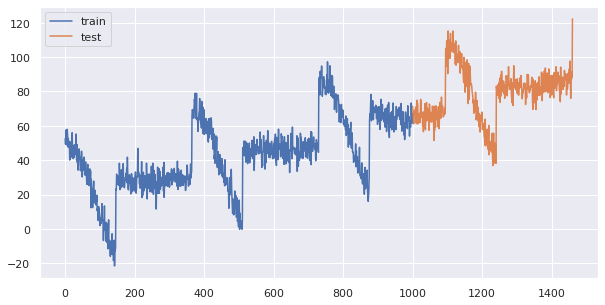

In [ ]:
%matplotlib inline
plt.figure(figsize = (10,5))
plt.plot(time_train, x_train, label = 'train')
plt.plot(time_valid, x_valid, label = 'test')
plt.legend()
plt.show()

In [ ]:
# Config of creating feature and label
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
# Experiment 1
t.manual_seed(1729)
np.random.seed(1729)

dataset = windowed_dataset(x_train, window_size, batch_size,
                           shuffle_buffer_size)

In [ ]:
# Model build
model = Sequential(Net(hidden_size=32))

In [ ]:
lr_schedule = [lambda epoch: 10.0 ** (epoch / 20)]
optimizer = optim.SGD(model.model.parameters(), lr=1e-8, momentum=0.9)
model.t_compile(loss=nn.SmoothL1Loss(), optimizer=optimizer, metric=mean_absolute_error)

In [ ]:
# Model train
history = model.t_fit(dataset, epochs=100, callbacks=lr_schedule)

epoch:  0 . Loss:  55.72263768513997
epoch:  1 . Loss:  55.58859354654948
epoch:  2 . Loss:  55.481635920206706
epoch:  3 . Loss:  55.35466639200846
epoch:  4 . Loss:  55.151238377888994
epoch:  5 . Loss:  54.98123664855957
epoch:  6 . Loss:  54.67445920308431
epoch:  7 . Loss:  54.60053278605143
epoch:  8 . Loss:  54.211924362182614
epoch:  9 . Loss:  53.95680732727051
epoch:  10 . Loss:  53.53630599975586
epoch:  11 . Loss:  53.2366221110026
epoch:  12 . Loss:  52.83974011739095
epoch:  13 . Loss:  52.37975222269694
epoch:  14 . Loss:  51.84223670959473
epoch:  15 . Loss:  51.21086146036784
epoch:  16 . Loss:  50.58721237182617
epoch:  17 . Loss:  49.73725255330404
epoch:  18 . Loss:  48.77049662272135
epoch:  19 . Loss:  47.85884920756022
epoch:  20 . Loss:  46.831579971313474
epoch:  21 . Loss:  45.61778475443522
epoch:  22 . Loss:  44.203848393758136
epoch:  23 . Loss:  42.67379951477051
epoch:  24 . Loss:  40.79339917500814
epoch:  25 . Loss:  39.018154335021975
epoch:  26 . Loss

(1e-08, 0.0001, 0.0, 30.0)

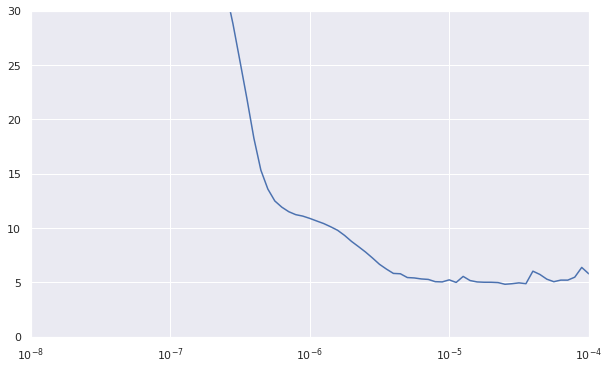

In [ ]:
# Plot
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
openfig()
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
savefig('1_exp1_resultsLoss_learningRates')

<Figure size 432x288 with 0 Axes>

In [ ]:
print(lrs[np.argmin(history.history['loss'])])

2.5118864315095798e-05


In [ ]:
# Experiment 2
t.manual_seed(1729)
np.random.seed(1729)

dataset2 = windowed_dataset(x_train, window_size, batch_size,
                            shuffle_buffer_size)


In [ ]:
model2 = Sequential(Net(hidden_size=32))
optimizer2 = optim.SGD(model2.model.parameters(), lr=1e-5, momentum=0.9)
model2.t_compile(loss=nn.MSELoss(), optimizer=optimizer2, metric=mean_absolute_error)
history2 = model2.t_fit(dataset2, epochs=500)

epoch:  0 . Loss:  661.504726155599
epoch:  1 . Loss:  170.4477263132731
epoch:  2 . Loss:  114.51972020467123
epoch:  3 . Loss:  77.1486005783081
epoch:  4 . Loss:  97.9122538248698
epoch:  5 . Loss:  85.23934415181478
epoch:  6 . Loss:  61.299845631917314
epoch:  7 . Loss:  83.20129661560058
epoch:  8 . Loss:  73.88497098286946
epoch:  9 . Loss:  79.90628077189128
epoch:  10 . Loss:  61.738166936238606
epoch:  11 . Loss:  55.4403605779012
epoch:  12 . Loss:  99.64789708455403
epoch:  13 . Loss:  82.03592274983724
epoch:  14 . Loss:  63.347829755147295
epoch:  15 . Loss:  54.866164207458496
epoch:  16 . Loss:  53.83442370096842
epoch:  17 . Loss:  59.8336576461792
epoch:  18 . Loss:  67.96655286153158
epoch:  19 . Loss:  56.07516231536865
epoch:  20 . Loss:  58.26323267618815
epoch:  21 . Loss:  64.00917536417643
epoch:  22 . Loss:  60.57964903513591
epoch:  23 . Loss:  52.84049676259359
epoch:  24 . Loss:  58.88991165161133
epoch:  25 . Loss:  53.97534008026123
epoch:  26 . Loss:  57

In [ ]:
forecast2 = []
for time in range(len(series) - window_size):
    forecast_feature2 = series[time:time + window_size][np.newaxis]
    forecast2.append(model2.t_predict(t.from_numpy(forecast_feature2)))

forecast2 = forecast2[split_time-window_size:]
results2 = t.cat(forecast2).detach().numpy()[:, 0]

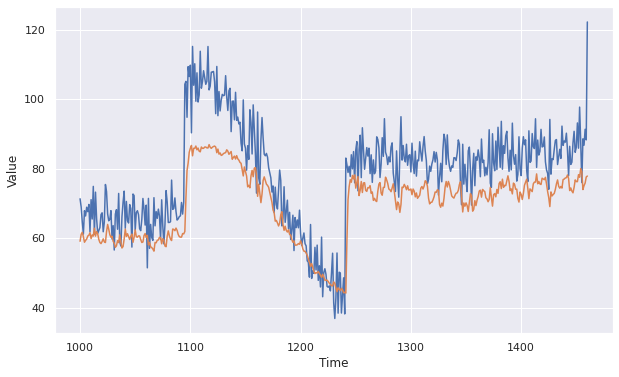

In [ ]:
openfig()
plot_series(time_valid, x_valid)
plot_series(time_valid, results2)

In [ ]:
savefig('2_exp2_forecast')

<Figure size 432x288 with 0 Axes>

In [ ]:
print(mean_absolute_error(x_valid, results2))

9.576943


In [ ]:
# Retrieve a list of list results on training and test data
# sets for each training epoch

mae2 = history2.history['mean_absolute_error']
loss2 = history2.history['loss']

epochs2 = range(len(loss2))  # Get number of epochs

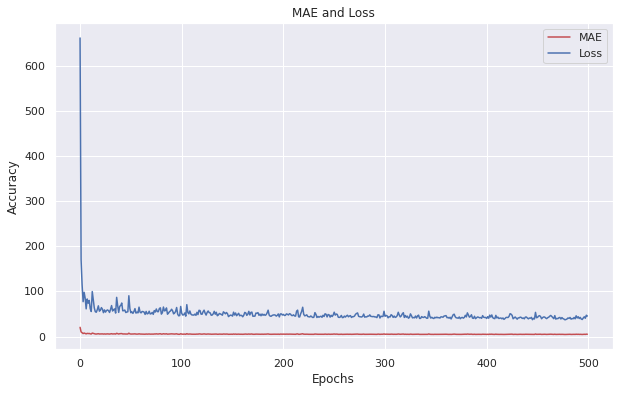

In [ ]:
# Plot MAE and Loss
openfig()
plt.plot(epochs2, mae2, 'r')
plt.plot(epochs2, loss2, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

In [ ]:
savefig('3_exp2_retrieve_training_mae_loss')

<Figure size 432x288 with 0 Axes>

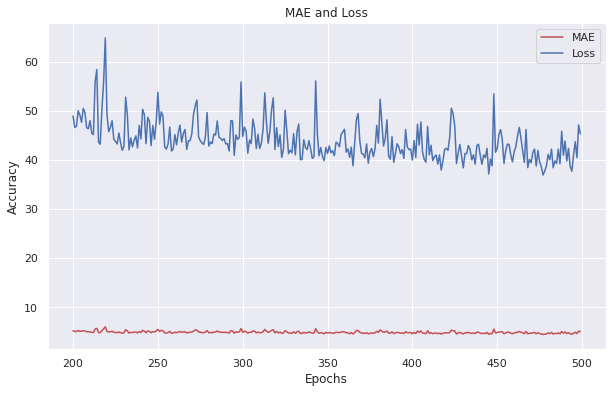

In [ ]:
# Plot Zoomed MAE and Loss
epochs2_zoom = epochs2[200:]
mae2_zoom = mae2[200:]
loss2_zoom = loss2[200:]
openfig()
plt.plot(epochs2_zoom, mae2_zoom, 'r')
plt.plot(epochs2_zoom, loss2_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

In [ ]:
savefig('4_exp2_retrieve_training_mae_loss_zoomin')

<Figure size 432x288 with 0 Axes>

In [ ]:
# Experiment 3
t.manual_seed(1729)
np.random.seed(1729)

In [ ]:
dataset3 = windowed_dataset(x_train, window_size, batch_size,
                            shuffle_buffer_size)

In [ ]:
model3 = Sequential(Net(hidden_size=32))
model3.t_compile(loss=nn.MSELoss(),
                 optimizer=optim.SGD(model3.model.parameters(), lr=1e-6,
                                     momentum=0.9), metric=mean_absolute_error)

In [ ]:
history3 = model3.t_fit(dataset3, epochs=100)

epoch:  0 . Loss:  737.9325948079427
epoch:  1 . Loss:  184.41312052408855
epoch:  2 . Loss:  89.16748415629068
epoch:  3 . Loss:  61.44231808980306
epoch:  4 . Loss:  56.809992090861
epoch:  5 . Loss:  56.331047948201494
epoch:  6 . Loss:  52.016676584879555
epoch:  7 . Loss:  54.53751799265544
epoch:  8 . Loss:  51.94795926411947
epoch:  9 . Loss:  50.00369059244792
epoch:  10 . Loss:  49.712731552124026
epoch:  11 . Loss:  49.15596268971761
epoch:  12 . Loss:  53.855201466878256
epoch:  13 . Loss:  56.373850695292155
epoch:  14 . Loss:  51.36183999379476
epoch:  15 . Loss:  49.41368560791015
epoch:  16 . Loss:  49.090684254964195
epoch:  17 . Loss:  47.89372316996256
epoch:  18 . Loss:  51.240081469217934
epoch:  19 . Loss:  47.693078231811526
epoch:  20 . Loss:  48.490183130900064
epoch:  21 . Loss:  49.008682060241696
epoch:  22 . Loss:  50.68254152933756
epoch:  23 . Loss:  56.5902935663859
epoch:  24 . Loss:  51.19628779093424
epoch:  25 . Loss:  48.30945453643799
epoch:  26 . L

In [ ]:
forecast3 = []
for time in range(len(series) - window_size):
    forecast_feature3 = series[time:time + window_size][np.newaxis]
    forecast3.append(model3.t_predict(t.from_numpy(forecast_feature3)))

In [ ]:
forecast3 = forecast3[split_time-window_size:]
results3 = t.cat(forecast3).detach().numpy()[:, 0]
print(mean_absolute_error(x_valid, results3))

5.534319


In [ ]:
# Experiment 4
t.manual_seed(1729)
np.random.seed(1729)

In [ ]:
dataset4 = windowed_dataset(x_train, window_size, batch_size,
                            shuffle_buffer_size)

In [ ]:
model4 = Sequential(Net4(hidden_size=32))
model4.t_compile(loss=nn.MSELoss(),
                 optimizer=optim.SGD(model4.model.parameters(), lr=1e-6,
                                     momentum=0.9), metric=mean_absolute_error)

In [ ]:
model4.t_fit(dataset4, epochs=100)

epoch:  0 . Loss:  595.5404744466146
epoch:  1 . Loss:  383.28431243896483
epoch:  2 . Loss:  311.6622812906901
epoch:  3 . Loss:  222.7046666463216
epoch:  4 . Loss:  134.68240025838216
epoch:  5 . Loss:  97.66664810180664
epoch:  6 . Loss:  77.54862899780274
epoch:  7 . Loss:  70.7789379119873
epoch:  8 . Loss:  63.70968488057454
epoch:  9 . Loss:  62.290893173217775
epoch:  10 . Loss:  59.46290690104167
epoch:  11 . Loss:  59.43899885813395
epoch:  12 . Loss:  59.45224170684814
epoch:  13 . Loss:  53.6492426554362
epoch:  14 . Loss:  54.79030316670735
epoch:  15 . Loss:  52.095781834920246
epoch:  16 . Loss:  52.07660967508952
epoch:  17 . Loss:  56.16812489827474
epoch:  18 . Loss:  57.54505208333333
epoch:  19 . Loss:  54.71561075846354
epoch:  20 . Loss:  55.05087661743164
epoch:  21 . Loss:  61.89314181009929
epoch:  22 . Loss:  55.57010313669841
epoch:  23 . Loss:  50.012370618184406
epoch:  24 . Loss:  52.79245630900065
epoch:  25 . Loss:  51.451252174377444
epoch:  26 . Loss:

In [ ]:
forecast4 = []
for time in range(len(series) - window_size):
    forecast_feature4 = series[time:time + window_size][np.newaxis]
    forecast4.append(model4.t_predict(t.from_numpy(forecast_feature4)))

In [ ]:
forecast4 = forecast4[split_time-window_size:]
results4 = t.cat(forecast4).detach().numpy()[:, 0]
print(mean_absolute_error(x_valid, results4))

5.495116
